In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestClassifier

## Feature Selection

In [4]:
feature_df = pd.read_csv("D:/4-PROJECT/CAPSTONE/Dataset/IFND.csv/feature_df.csv")
feature_df.head()

,processed_statement,Web,Category,Word Count,Text Length,sentiment_eval,class_sentiment,Label_num
0,praise india aarogya setu app say helped ident...,DNAINDIA,COVID-19,11,69,0.5267,Positive,1
1,delhi deputy u secretary state stephen biegun ...,DNAINDIA,VIOLENCE,11,69,0.0000,Neutral,1
2,lac tension china strategy behind deliberately...,DNAINDIA,TERROR,9,65,-0.7184,Negative,1
3,india signed 250 document space cooperation 59...,DNAINDIA,COVID-19,10,65,0.0000,Neutral,1
4,tamil nadu chief minister mother pass away 93,DNAINDIA,ELECTION,8,45,0.0000,Neutral,1


In [5]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54804 entries, 0 to 54803
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   processed_statement  54804 non-null  object 
 1   Web                  54804 non-null  object 
 2   Category             54804 non-null  object 
 3   Word Count           54804 non-null  int64  
 4   Text Length          54804 non-null  int64  
 5   sentiment_eval       54804 non-null  float64
 6   class_sentiment      54804 non-null  object 
 7   Label_num            54804 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [6]:
feature_df['Label_num'].value_counts()

Label_num
1    35951
0    18853
Name: count, dtype: int64

### Train Test Split

In [7]:
x = feature_df[['processed_statement','Web', 'Category', 'Word Count', 'Text Length', 'sentiment_eval', 'class_sentiment']]
y = feature_df["Label_num"]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(38362, 7)
(16442, 7)
(38362,)
(16442,)


## Model Building

In [9]:
# Preprocessing for numerical features
numerical_features = ['Word Count', 'Text Length', 'sentiment_eval']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Preprocessing for categorical features
categorical_features = ['Category', 'Web', 'class_sentiment']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Preprocessing for text features
textual_features = ['processed_statement']
textual_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', textual_transformer, 'processed_statement')])

In [10]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Word Count', 'Text Length',
                                  'sentiment_eval']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Category', 'Web', 'class_sentiment']),
                                ('text',
                                 Pipeline(steps=[('tfidf', TfidfVectorizer())]),
                                 'processed_statement')])

### Logistic Regression

In [11]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])


pipeline.fit(x_train, y_train)

# Predict on test data
y_pred = pipeline.predict(x_test)


In [12]:
(pd.DataFrame(y_pred)).value_counts()

1    10784
0     5658
Name: count, dtype: int64

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5646
           1       0.99      0.99      0.99     10796

    accuracy                           0.99     16442
   macro avg       0.99      0.99      0.99     16442
weighted avg       0.99      0.99      0.99     16442



In [14]:
## !pip install seaborn --upgrade


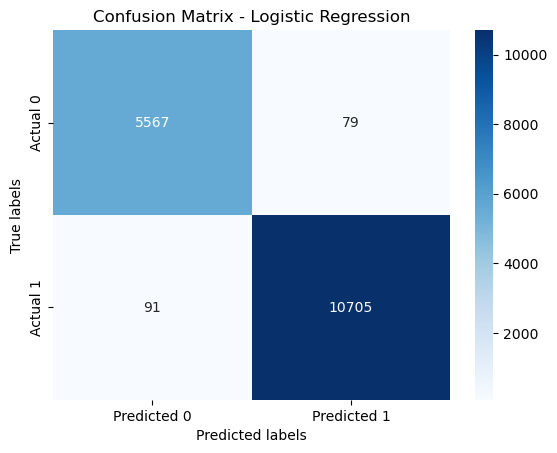

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [16]:
conf_matrix

array([[ 5567,    79],
       [   91, 10705]], dtype=int64)

## Decision Tree

In [17]:
# Define the pipeline for decision tree classifier without pruning (ccp_alpha=0.0)
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(ccp_alpha=0.01)) 
])

# Fit the pipeline on training data
pipeline_dt.fit(x_train, y_train)

# Get the maximum depth of the unpruned decision tree
max_depth_pruned = pipeline_dt.named_steps['classifier'].get_depth()

print("Equivalent depth value for alpha=0.01:", max_depth_pruned)


Equivalent depth value for alpha=0.01: 6


In [18]:
# Define the pipeline for decision tree classifier with a specified max_depth
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=6))  # Specifying max_depth
])

# Fit the pipeline on training data
pipeline_dt.fit(x_train, y_train)

# Predict on test data
y_pred_dt = pipeline_dt.predict(x_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Model Accuracy:", accuracy_dt)

Decision Tree Model Accuracy: 0.9618659530470746


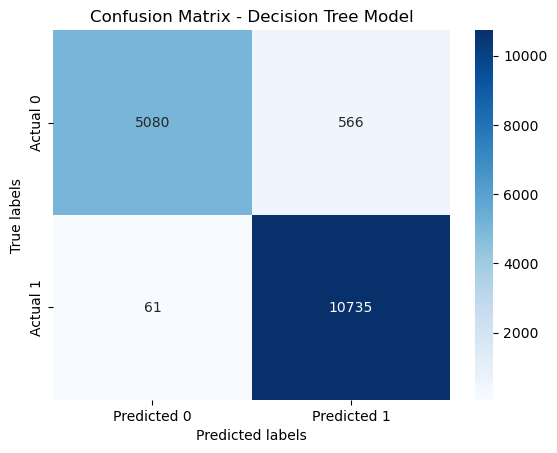

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree Model')
plt.show()


In [17]:
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
conf_matrix_dt

array([[ 5079,   567],
       [   61, 10735]], dtype=int64)

In [18]:
(pd.DataFrame(y_pred_dt)).value_counts()

1    11302
0     5140
Name: count, dtype: int64

In [19]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      5646
           1       0.95      0.99      0.97     10796

    accuracy                           0.96     16442
   macro avg       0.97      0.95      0.96     16442
weighted avg       0.96      0.96      0.96     16442



In [20]:
# Extract feature importance
feature_importance = pipeline_dt.named_steps['classifier'].feature_importances_

# Sort feature importance in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_indices]

# Print feature importance in descending order
print("Feature Importance (Descending Order):")
for i, importance in zip(sorted_indices, sorted_importance):
    print(f"Feature {i}: {importance}")

Feature Importance (Descending Order):
Feature 13: 0.5847204327252058
Feature 29: 0.13237809039891263
Feature 26: 0.11186815421152618
Feature 6: 0.06572758068259647
Feature 14: 0.055745232738193054
Feature 30: 0.036749489746723076
Feature 0: 0.004991686430141366
Feature 4: 0.002190028849161939
Feature 8: 0.0018798696938574545
Feature 6127: 0.0013893863000879344
Feature 16915: 0.0011269703389067578
Feature 12742: 0.0007477023595870042
Feature 14346: 0.000231159048636103
Feature 18421: 0.0001287301357761812
Feature 9393: 0.0001254863406881703
Feature 7016: 0.0
Feature 6972: 0.0
Feature 6965: 0.0
Feature 6966: 0.0
Feature 6967: 0.0
Feature 6968: 0.0
Feature 6969: 0.0
Feature 6970: 0.0
Feature 6971: 0.0
Feature 6973: 0.0
Feature 6982: 0.0
Feature 6974: 0.0
Feature 6975: 0.0
Feature 6976: 0.0
Feature 6977: 0.0
Feature 6978: 0.0
Feature 6979: 0.0
Feature 6980: 0.0
Feature 6964: 0.0
Feature 6963: 0.0
Feature 6962: 0.0
Feature 6961: 0.0
Feature 6948: 0.0
Feature 6949: 0.0
Feature 6950: 0.0
Fea

## Random Forest

In [21]:
# Define the pipeline for Random Forest classifier with a specified max_depth
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=7))  # Specifying n_estimators and max_depth
])

# Fit the pipeline on training data
pipeline_rf.fit(x_train, y_train)

# Predict on test data
y_pred_rf = pipeline_rf.predict(x_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Model Accuracy:", accuracy_rf)

# Print confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)

Random Forest Model Accuracy: 0.6835543121274784
Confusion Matrix for Random Forest:
[[  443  5203]
 [    0 10796]]


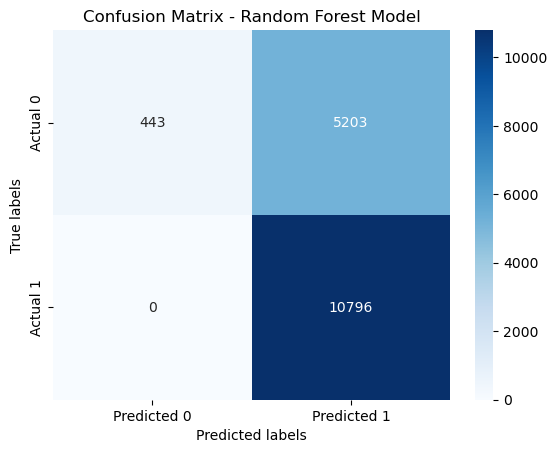

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Model')
plt.show()

In [22]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.05      0.09      5646
           1       0.67      1.00      0.80     10796

    accuracy                           0.67     16442
   macro avg       0.83      0.52      0.44     16442
weighted avg       0.78      0.67      0.56     16442



In [23]:
# Extract feature importance
feature_importance_rf = pipeline_rf.named_steps['classifier'].feature_importances_

# Sort feature importance in descending order
sorted_indices_rf = feature_importance_rf.argsort()[::-1]
sorted_importance_rf = feature_importance_rf[sorted_indices_rf]

# Print feature importance in descending order
print("Feature Importance (Random Forest - Descending Order):")
for i, importance in zip(sorted_indices_rf, sorted_importance_rf):
    print(f"Feature {i}: {importance}")

Feature Importance (Random Forest - Descending Order):
Feature 13: 0.04649583112583186
Feature 36: 0.0350458560632415
Feature 34: 0.032422139453465136
Feature 20209: 0.02813014335294832
Feature 7342: 0.026116271520377037
Feature 0: 0.02554394767714122
Feature 20292: 0.025273922981533282
Feature 1: 0.02256640991328264
Feature 29: 0.022455241687735016
Feature 19472: 0.022314807396389535
Feature 8: 0.022149810309249323
Feature 26: 0.022011973377782917
Feature 17183: 0.02030946961931761
Feature 6: 0.018758682720218463
Feature 9393: 0.01714704448254635
Feature 13383: 0.017086883315634405
Feature 14209: 0.017035080858960872
Feature 33: 0.016743833696895357
Feature 4286: 0.015269382183907085
Feature 2834: 0.015167721454297338
Feature 13017: 0.014852097449311229
Feature 14178: 0.014493901138220711
Feature 7351: 0.013413884893263934
Feature 10: 0.012910940702301756
Feature 4: 0.010987345970198563
Feature 11: 0.010519928255338951
Feature 14: 0.010516564643426445
Feature 25: 0.00889851404612994
F